In [1]:
pip install datasets


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from datasets import load_dataset
# Load the dataset
dataset = load_dataset("emotion")
# Check available splits
print(dataset)
# View a sample
print(dataset["train"][0])

c:\Users\Pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Pc\.cache\huggingface\hub\datasets--emotion. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order 

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})
{'text': 'i didnt feel humiliated', 'label': 0}


In [3]:
label_names = dataset['train'].features['label'].names
print(label_names)  # ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


# EDA

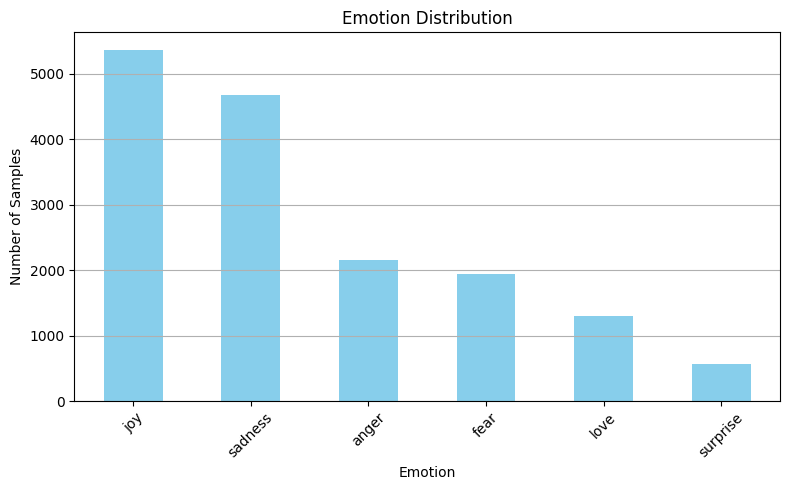

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert HuggingFace dataset to pandas DataFrame
df_train = pd.DataFrame(dataset["train"])
df_train['emotion'] = df_train['label'].apply(lambda x: dataset['train'].features['label'].int2str(x))

# Plot class distribution
plt.figure(figsize=(8, 5))
df_train['emotion'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [5]:
import re

# Define text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)                # remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)            # remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()           # remove extra spaces
    return text

# Apply to dataframe
df_train['clean_text'] = df_train['text'].apply(clean_text)

# Preview results
df_train[['text', 'clean_text', 'emotion']].head()


,text,clean_text,emotion
0,i didnt feel humiliated,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,i am feeling grouchy,anger


In [6]:
df_train = df_train[df_train['clean_text'].str.len() > 2]
#To remove very short or empty clened text

In [7]:
# Step 4.1: Split data
# ---------------------
# We split the cleaned text and emotion labels into training and testing sets (80/20)

from sklearn.model_selection import train_test_split

X = df_train['clean_text']           # input texts
y = df_train['emotion']              # emotion labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

Train size: 12800
Test size: 3200


In [8]:
# Step 4.2: Convert text to numeric features using TF-IDF
# --------------------------------------------------------
# TF-IDF assigns importance to words based on their frequency

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)   # limit to top 5000 words
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"TF-IDF shape (train): {X_train_vec.shape}")

TF-IDF shape (train): (12800, 5000)


In [9]:
# Step 4.3: Train the emotion classifier
# --------------------------------------
# We'll use a Linear Support Vector Classifier

from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(X_train_vec, y_train)

print("✅ Model training complete!")

✅ Model training complete!


c:\Users\Pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


📄 Classification Report:
              precision    recall  f1-score   support

       anger       0.89      0.89      0.89       427
        fear       0.86      0.85      0.85       397
         joy       0.89      0.93      0.91      1021
        love       0.80      0.74      0.77       296
     sadness       0.92      0.93      0.93       946
    surprise       0.90      0.69      0.78       113

    accuracy                           0.89      3200
   macro avg       0.88      0.84      0.86      3200
weighted avg       0.89      0.89      0.89      3200



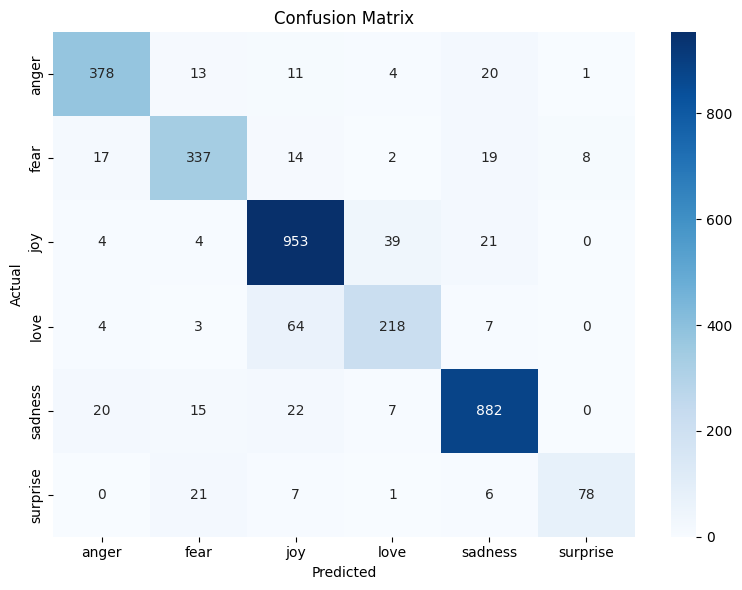

In [12]:
# Step 4.4: Evaluate the model on test data
# -----------------------------------------

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test set
y_pred = model.predict(X_test_vec)

# Print classification report
print("📄 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=model.classes_, yticklabels=model.classes_, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [13]:
# Step 5.1: Save trained model and vectorizer
# -------------------------------------------

import pickle
import os

# Create directory if not exists
os.makedirs("../models", exist_ok=True)

# Save classifier
with open("../models/emotion_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save TF-IDF vectorizer
with open("../models/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("✅ Model and vectorizer saved successfully!")

✅ Model and vectorizer saved successfully!
